In the 1990s Rick Rosenfeld and Norm White used police records to collect data on crime in St. Louis. They began with five homicides and recorded the names of all the individuals who had been involved as victims, suspects or witnesses. They then explored the files and recorded all the other crimes in which those same individuals appeared. This snowball process was continued until they had data on 557 crime events. Those events involved 870 participants of which: 569 appeared as victims 682 appeared as suspects 195 appeared as witnesses, and 41 were dual (they were recorded both as victims and suspects in the same crime). Their data appear, then, as an 870x557, individual-by-crime event matrix. Victims are coded as 1, suspects as 2, witnesses as 3 and duals as 4.

We used the island method (Tsvetovat, Maksim; Kouznetsov, Alexander. Social Network Analysis for Startups, O'Reilly Media) to identify connected subgroups in the data. 

Unzip the file to create a folder in our directory

In [2]:
#fp = tarfile.open("zen.tar.gz","r:gz")
import tarfile
fp = tarfile.open("moreno_crime.tar.bz2","r:bz2")     
fp.extractall()      
fp.close()

In [ ]:
Load the crime data and the relationship between person

In [116]:
import pandas as pd
# loading crime data
crime_data='moreno_crime/out.moreno_crime_crime'
crime = pd.read_csv(crime_data, delim_whitespace=True, header=None, skiprows=[0,1], names=['Person', 'Crime'])

# loading relationship data
data_rel = 'moreno_crime/rel.moreno_crime_crime.person.role'
crime['Relationship'] = pd.read_csv(data_rel, header=None)
crime.head()

,Person,Crime,Relationship
0,1,1,Suspect
1,1,2,Victim
2,1,3,Victim
3,1,4,Suspect
4,2,5,Victim


In [117]:
#Number of people
len(crime.Person.unique())

829

In [118]:
#Number of crimes
len(crime.Crime.unique())

551

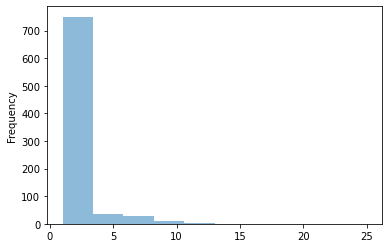

In [119]:
#histogram of crime_count
import matplotlib.pyplot as plot
crime_count = pd.DataFrame({'Count': crime.groupby(['Person']).size()}).reset_index()
crime_count.iloc[:,1].plot.hist(alpha=0.5, bins=10)
#plot.xlabel('Crimes')
#plot.ylabel('Persons')
# plt.title('Distribution of Crimes by Person', loc='left', fontsize=24)
#plt.grid(True)
    

Most of the persons comit one single crime

In [120]:
## segregating attributes here to get a relationship count and a total crime count 
crime2 = crime
crime2['rel_count'] = crime2.groupby(['Person', 'Relationship'])['Crime'].transform('count')
crime2['crime_count'] = crime2.groupby(['Person'])['Crime'].transform('count')
crime2.head()

,Person,Crime,Relationship,rel_count,crime_count
0,1,1,Suspect,2,4
1,1,2,Victim,2,4
2,1,3,Victim,2,4
3,1,4,Suspect,2,4
4,2,5,Victim,4,22


In [ ]:
Identify the persons by sex

In [158]:
data_names = 'moreno_crime/ent.moreno_crime_crime.person.name'
names = pd.read_csv(data_names, sep='\t', header=None)
#print(names)

# loading sex data
data_sex = 'moreno_crime/ent.moreno_crime_crime.person.sex'
#print(data_sex)

names['Sex'] = pd.read_csv(data_sex, header=None)

#print(names['Sex'])
#df.iloc[0, df.columns.get_loc('COL_NAME')] = x
names.loc[names.Sex==1,names.columns.get_loc('Sex')]='M'

names.loc[names.Sex == 0, names.columns.get_loc('Sex')]='F'

# replacing left nodes (people involved in a crime) with names and adding sex
# Right nodes stay as numbers to identify as crimes, not people
for i in range(0,len(names)):
    crime2.loc[crime2.Person == i+1, names.columns.get_loc('Sex')]= names.loc[i][1]
    crime2.loc[crime2.Person == i+1, names.columns.get_loc(0)]= names.loc[i][0]
    
crime2.head()

,Person,Crime,Relationship,rel_count,crime_count,1,0
0,1,1,Suspect,2,4,M,AbelDennis
1,1,2,Victim,2,4,M,AbelDennis
2,1,3,Victim,2,4,M,AbelDennis
3,1,4,Suspect,2,4,M,AbelDennis
4,2,5,Victim,4,22,M,AbramsChad


In [ ]:
Create a graph object with edges

In [296]:
person=[]
crme=[]
g = nx.Graph()
for i in range(0, len(crime2)):
    if crime2.iloc[i][0] not in person:
        person.append(crime2.iloc[i][0])
    if crime2.iloc[i][1] not in crme:
        crme.append(crime2.iloc[i]['Crime'])
    g.add_edge(crime2.iloc[i][0], crime2.iloc[i]['Crime'], weight=int(crime2.iloc[i]['crime_count']))
    

In [300]:
personnet=bi.weighted_projected_graph(g, person, ratio=False)

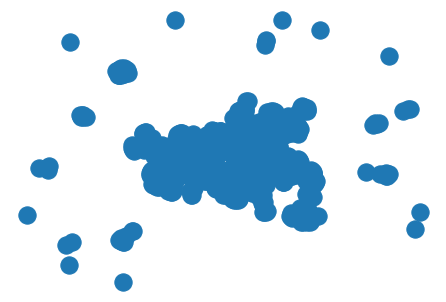

In [301]:
nx.draw(personnet)

To determine whether people involved in multiple crimes are connected in some way (a criminal or victim network), we need to create a projected bipartite graph on Persons.

In [302]:
# identify largest connected component
Gcc = sorted(nx.connected_components(personnet), key=len, reverse=True)
pnet = personnet.subgraph(Gcc[0])
#nx.draw_networkx_edges(G0, pos,
                        #with_labels=False,
                        #edge_color='r',
                        #width=6.0
                          #)
    # show other connected components
#for Gi in Gcc[1:]:
    #if len(Gi) > 1:
        #nx.draw_networkx_edges(personnet.subgraph(Gi), pos,
                                #with_labels=False,
                                #edge_color='r',
                                #alpha=0.3,
                                #width=5.0
                                 # )
#plot.show()


We adapt the island method from Tsvetovat, et al, after creating a weighted bipartite graph. Weights are the number of shared neighbors for an edge

In [385]:
weights=[edata['weight'] for f,t,edata in pnet.edges(data=True)]

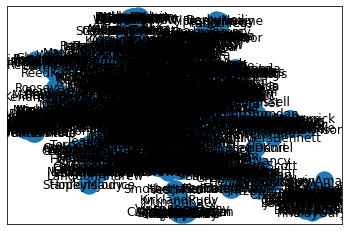

In [386]:
nx.draw_networkx(pnet,width=weights, edge_color=weights)

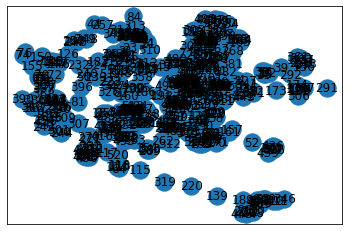

In [306]:
crmenet=bi.weighted_projected_graph(g, crme, ratio=False)
Gcc = sorted(nx.connected_components(crmenet), key=len, reverse=True)
cnet= crmenet.subgraph(Gcc[0])
weights=[math.log(edata['weight']) for f,t,edata in cnet.edges(data=True)]
nx.draw_networkx(cnet,width=weights, edge_color=weights)

(array([2156.,    0.,    0.,    0.,    0.,    0.,  121.,    0.,    0.,
           7.]),
 array([0.        , 0.10986123, 0.21972246, 0.32958369, 0.43944492,
        0.54930614, 0.65916737, 0.7690286 , 0.87888983, 0.98875106,
        1.09861229]),
 <a list of 10 Patch objects>)

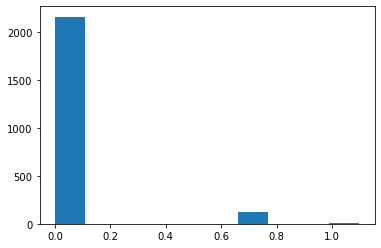

In [345]:
def trim_edges(g, weight=1):
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True):
         #print([f,to,edata])
         if edata['weight'] > weight:
             g2.add_edge(f,to,weight=edata['weight'])
    return g2
plot.hist(weights)


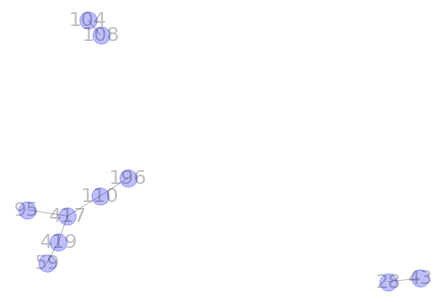

In [375]:
crc = trim_edges(cnet, 2)
dcrc = crc.degree()
nx.draw(crc,  with_labels=True, node_color='b', alpha=.25, font_size=20)

In [358]:
def island_method(g, iterations=1):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    print(mn)
    mx=int(max(weights))
    print(mx)
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/iterations)
    print(step)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [359]:
islands=island_method(cnet)

1
3
2


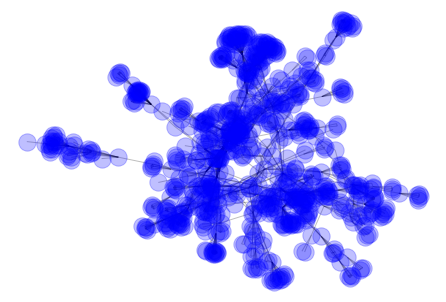

In [371]:
## The weights histogram is logarithmic;
## we should compute the original weight = e^log_weight
pnet_trim=trim_edges(pnet, weight=1)
dpnet = pnet_trim.degree()
#len(dpnet)
nx.draw(pnet, node_color='b', alpha=.25, font_size=20)


In [380]:
def sorted_map(m):
    #map_dict =dict(m)
    ms = sorted(m, key=m.__getitem__, reverse=True)
    return ms

Betweenness centrality: We will study in this section which peron that plays a central role. 

In [381]:
# Betweenness centrality
btn=nx.betweenness_centrality(G2)
ds=sorted_map(btn)
ds[0:10]

['WillisJenny',
 110,
 'SlatteryMaurice',
 23,
 160,
 47,
 'AbramsChad',
 46,
 14,
 'SteinerCatherine']

In [382]:
cent=nx.degree_centrality(G2)
dcent=sorted_map(cent)
dcent[0:10]

['WillisJenny',
 'AbramsChad',
 'KatzLuella',
 110,
 'DicksonCarter',
 153,
 'BendixJerryLee',
 14,
 43,
 95]

Eigenvector centrality Based on the importance of a person in the crime we will determine the importance for a node.

In [384]:
eg=nx.eigenvector_centrality(G2)
egs=sorted_map(eg)
egs[:10]

[110,
 'KatzLuella',
 'SteinerCatherine',
 95,
 'SmithMichaelThomas',
 417,
 419,
 43,
 'JohnstonJustin',
 'MitchellGrant']